In [ ]:
# Step 0:Importing modules
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from pathlib import Path
from collections import Counter
from PIL import Image
import random
import matplotlib.pyplot as plt


Classes found in dataset:
['bird', 'drone']

Number of images per class:
bird: 1414
drone: 1248


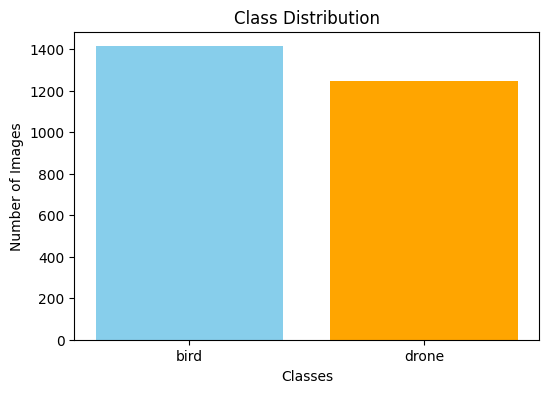

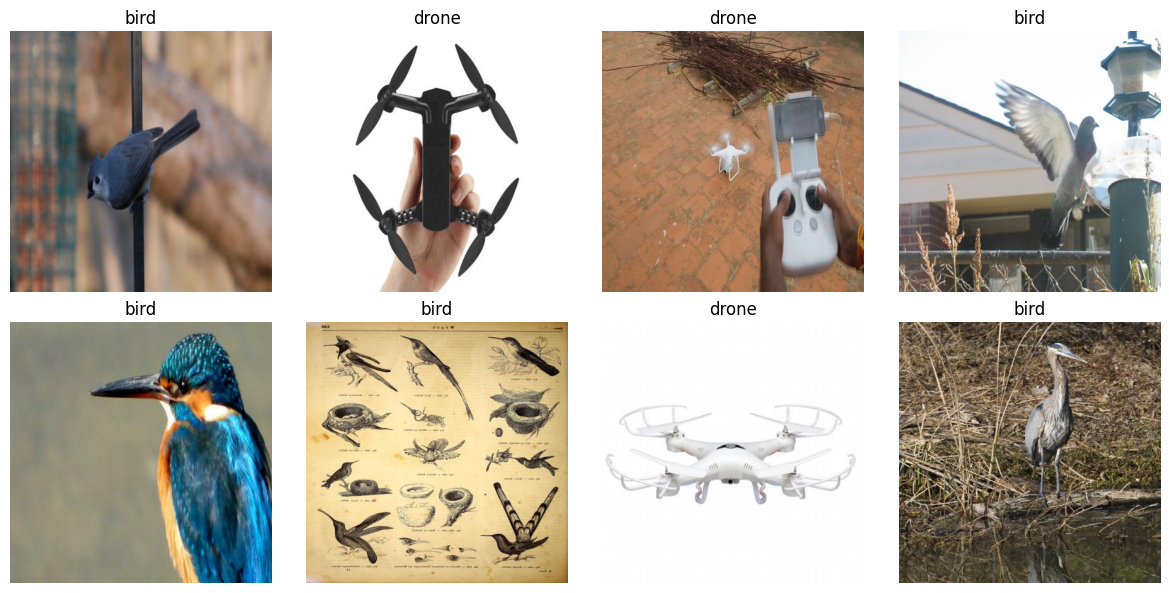

In [ ]:
# Step 1: Understand the Dataset

# --- 1. Set dataset path ---
dataset_dir = Path(r"C:\Users\jainka\OneDrive - Hewlett Packard Enterprise\DS-C-WE-E-B57\Aerial Object Classification & Detection\train-20251011T170123Z-1-001\train")  

# --- 2. Inspect folder structure ---
print("Classes found in dataset:")
classes = [c.name for c in dataset_dir.iterdir() if c.is_dir()]
print(classes)

# --- 3. Count number of images per class ---
counts = {c.name: len(list(c.glob("*.*"))) for c in dataset_dir.iterdir() if c.is_dir()}
print("\nNumber of images per class:")
#print(counts)
for cls, cnt in counts.items():
    print(f"{cls}: {cnt}")

# --- 4. Check class imbalance visually ---
plt.figure(figsize=(6,4))
plt.bar(counts.keys(), counts.values(), color=['skyblue', 'orange'])
plt.title("Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.show()

#displaying a few random images
# --- 5. Visualize sample images ---
num_samples = 8  # total samples to display
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axs.flat):
    cls = random.choice(classes)  # pick a random class
    img_path = random.choice(list((dataset_dir/cls).glob("*.*")))
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(cls)
    ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# Step 2: Loading the Dataset
train_dir = r"C:\Users\jainka\OneDrive - Hewlett Packard Enterprise\DS-C-WE-E-B57\Aerial Object Classification & Detection\train-20251011T170123Z-1-001\train"
valid_dir = r"C:\Users\jainka\OneDrive - Hewlett Packard Enterprise\DS-C-WE-E-B57\Aerial Object Classification & Detection\valid-20251011T170127Z-1-001\valid"
test_dir  = r"C:\Users\jainka\OneDrive - Hewlett Packard Enterprise\DS-C-WE-E-B57\Aerial Object Classification & Detection\test-20251011T170122Z-1-001\test"


#model will process 32 images at a time
batch_size = 32
# height and width of every image. Even if your original image is 400×300 or 1024×768,
#it will be resized to 224×224 before feeding into the model.
img_size = 224
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Step 3: Data Preprocessing and Augmentation
train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),# Makes all images the same size (224×224)
    transforms.RandomRotation(25),#Rotates image randomly up to ±25°
    transforms.RandomHorizontalFlip(),#Flips image 
    transforms.RandomResizedCrop(img_size, scale=(0.8,1.0)),#Crops a random region and resizes
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Randomly changes brightness and contrast
    transforms.ToTensor(), # Converts image (0–255) → tensor (0–1 range)
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Adjusts image to have standard mean & std
])

valid_test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


In [ ]:
# Step 4:Load Datasets
#Looks inside your training folder (train_dir)
#Each subfolder inside represents a class label (e.g., bird/, drone/).
#PyTorch automatically assigns those labels based on folder names.
#Data Loader - Loads data in batches (e.g., 32 images at a time → batch_size = 32)

train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_test_transforms)
test_data  = datasets.ImageFolder(test_dir,  transform=valid_test_transforms)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False)


In [45]:
train_data.class_to_idx

{'bird': 0, 'drone': 1}

In [ ]:
# Step 5: Model (Transfer Learning Example: ResNet50)

model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # freeze pretrained layers (weights are not updated during training)

print(model)

num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128,1),
    nn.Sigmoid()
)
model = model.to(device) # Sends the model to GPU (if available) or CPU.


c:\Users\jainka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jainka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Step 6:Training Setup
criterion = nn.BCELoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1, Loss: 0.2747
Epoch 2, Loss: 0.1592
Epoch 3, Loss: 0.1373
Epoch 4, Loss: 0.1345
Epoch 5, Loss: 0.1245
Epoch 6, Loss: 0.1038
Epoch 7, Loss: 0.1179
Epoch 8, Loss: 0.1072
Epoch 9, Loss: 0.1160
Epoch 10, Loss: 0.1076


              precision    recall  f1-score   support

        Bird       0.95      1.00      0.97       121
       Drone       1.00      0.93      0.96        94

    accuracy                           0.97       215
   macro avg       0.97      0.96      0.97       215
weighted avg       0.97      0.97      0.97       215



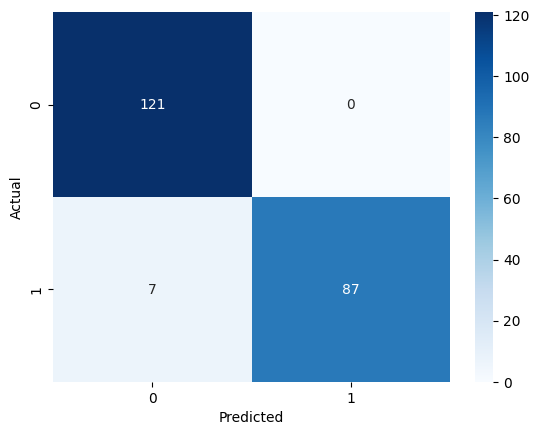

In [ ]:
# Step 7:Evaluation on Test Set
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = (outputs.cpu() > 0.5).int()
        y_pred.extend(preds.numpy())
        y_true.extend(labels.numpy())

print(classification_report(y_true, y_pred, target_names=['Bird','Drone']))
#Metric	What it measures
#Precision	Of all the times the model predicted a class, how many were actually correct? (“How accurate are my positive predictions?”)
#Recall	Of all the actual samples of a class, how many did the model correctly identify? (“How many of the actual positives did I find?”)

# the model correctly predicted all Birds
# 7 drones were misclassified as Birds
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
# Step 8: Save the Model
torch.save(model.state_dict(), "best_model.pth")

In [ ]:
# Optional: Object Detection with YOLOv8

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')  # smallest model pretrained model

model.train(
    data=r'C:\Users\jainka\OneDrive - Hewlett Packard Enterprise\DS-C-WE-E-B57\object_detection_Dataset-20251013T164300Z-1-001\object_detection_Dataset\data.yaml',
    epochs=5,       # fewer epochs
    imgsz=416,      # smaller image size
    batch=4,        # smaller batch
    workers=0       # avoids multiprocessing slowdown
)



New https://pypi.org/project/ultralytics/8.3.214 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.213  Python-3.11.2 torch-2.8.0+cpu CPU (11th Gen Intel Core i7-1165G7 @ 2.80GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\jainka\OneDrive - Hewlett Packard Enterprise\DS-C-WE-E-B57\object_detection_Dataset-20251013T164300Z-1-001\object_detection_Dataset\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=30

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001F2AEB40750>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0

In [ ]:
# runs evaluation/validation on the validation dataset specified in your data.yaml
metrics = model.val()  # returns metrics like mAP, precision, recall
print(metrics)

Ultralytics 8.3.213  Python-3.11.2 torch-2.8.0+cpu CPU (11th Gen Intel Core i7-1165G7 @ 2.80GHz)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.1 ms, read: 39.89.4 MB/s, size: 16.3 KB)
val: Scanning C:\Users\jainka\OneDrive - Hewlett Packard Enterprise\DS-C-WE-E-B57\object_detection_Dataset-20251013T164300Z-1-001\object_detection_Dataset\valid\labels.cache... 448 images, 6 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 448/448 136.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 28/28 0.9it/s 32.1s1.1ss
                   all        448        663      0.758      0.708       0.75      0.459
                  Bird        217        414      0.737      0.563      0.623      0.345
                 drone        225        249       0.78      0.854      0.878      0.574
Speed: 1.1ms preprocess, 63.4ms inference, 0.0ms loss, 0.8ms postprocess per image
Result

In [35]:
results = model.predict(r'C:\Users\jainka\OneDrive - Hewlett Packard Enterprise\DS-C-WE-E-B57\object_detection_Dataset-20251013T164300Z-1-001\object_detection_Dataset\test\images\0a7e246b483ed57b_jpg.rf.446903614d856f120545c0fc350c2209.jpg')
results[0].show()  # displays image with bounding boxes
results[0].save('predictions/')  # save prediction images



image 1/1 C:\Users\jainka\OneDrive - Hewlett Packard Enterprise\DS-C-WE-E-B57\object_detection_Dataset-20251013T164300Z-1-001\object_detection_Dataset\test\images\0a7e246b483ed57b_jpg.rf.446903614d856f120545c0fc350c2209.jpg: 416x416 1 Bird, 37.7ms
Speed: 2.9ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)


'predictions/'